<div align=center><font size=5>A Price Prediction Model for Airbnb Houses Based on Text Mining and Image Analysis</font></div>

<div align=center><font size=4>Jingwei Dai and Jieteng Chen</font></div>

<div align=center><font size=4>Contents</font></div>

<font size=4>Part 1. Background and Data Descriptions</font>

<font size=4>Part 2. Text Mining of Reviews: Topic Modelling, LDA Model, and Sentiment Analysis</font>

<font size=4>Part 3. Image Analysis: K-Means Clustering and OpenCV, Detecting the Color Tone of the Pictures</font>

<font size=4>Part 4. Regression Analysis, Cross Validation, Alternative Measurement for Robustness Check, and Discussion</font>

<font size=4>Part 5. Conclusion and Discussion</font>

# Background and Descriptions


## Background and Descriptions


Our data documents the listings of airbnb houses in New York City on Sep. 2nd, 2021, and their characteristics, including picture URLs, review details, prices, locations, etc. We intend to utilize the house attributes to predict their listing prices, serving as a model for hosts to price their properties. 

We firstly use LDA model to process the house reviews for sentiment analysis, to reflect how previous consumers think about the listing. This is important since many of us would be concerned about first-hand staying experience, and care a lot about reviews. Thus this step helps us quantify the effect of reviews. In section 3, we focus on pictures. We use K-Means clustering and opencv to analyze the pictures of the listings and then get the color tone. Our hypothesis is that warm color tone would be more beneficial for house sales since they are perceived as having more affinity. After getting these two main new features which have hardly been explored in marketing research before, we combine other features, including locations, accommodates, rating to do regression analysis. We employ various regression models and use cross-validation methods to select the best parameters. The results show that our method works well. We believe this research is a good application of machine learning methods in marketing research, and has the potential to generate new business implications.


In [39]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import names
from nltk.corpus import wordnet as wn
import gensim
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis
import pyLDAvis.gensim
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [37]:
nltk.download('stopwords')
nltk.download('words')
nltk.download('names')
nltk.download('wordnet')
nltk.download('vader_lexicon')


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/elft21/jietechen3/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /home/elft21/jietechen3/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package names to
[nltk_data]     /home/elft21/jietechen3/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/elft21/jietechen3/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/elft21/jietechen3/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Text Mining of Reviews: Topic Modelling, LDA Model, and Sentiment Analysis

In this section, we would do natural language processing. We employ topic modeling methods and LDA Model to do sentiment analysis for the reviews of Airbnb houses, so as to obtain how previous renters view and comment the houses and the hosts. We would generate a variable that quantifies the overall attitude of each comment, composing from their positive, negative, and neural attitude respectively. Then we would use the outcome as an important variable for later regression and comprehensive analysis, so as to represent and quantify the effect of Word-of-Mouth on prices.

## Data Cleaning

### Load Datasets

In [5]:
reviews = pd.read_csv('reviews.csv')
listings = pd.read_csv('listings.csv', low_memory = False,encoding = "ISO-8859-1")
# select columns in reviews df that are useful later
reviews0 = reviews[['listing_id', 'comments']]
reviews1 = reviews0.dropna(axis=0, how='any')
reviews2 = reviews1.rename(columns = {'listing_id':'id'})
# select columns in listings df that are useful later
listings0 = listings[['id', 'host_is_superhost', 'price', 'number_of_reviews', 'review_scores_rating']]
listings1 = listings0.dropna(axis=0, how='any')

In [7]:
dfmerge = pd.merge(reviews2, listings1, on = 'id', how = 'left')
dfmerge.head()

,id,comments,host_is_superhost,price,number_of_reviews,review_scores_rating
0,2595,Notre séjour de trois nuits.\r<br/>Nous avons ...,f,$150.00,48.0,4.7
1,2595,Great experience.,f,$150.00,48.0,4.7
2,2595,I've stayed with my friend at the Midtown Cast...,f,$150.00,48.0,4.7
3,2595,"We've been staying here for about 9 nights, en...",f,$150.00,48.0,4.7
4,2595,We had a wonderful stay at Jennifer's charming...,f,$150.00,48.0,4.7


### Remove Abnormal Comments

In [8]:
#Remove AutoReview
def autoreview(x):
    if 'an automated posting' in x:
        return '1'
    else:
        return '0'
dfmerge['autoreview'] = dfmerge['comments'].apply(autoreview)

In [9]:
#Remove non-English comments
# get nonenglish stopwords
stopwords_en = set(stopwords.words('english')) #english stopwords
stopwords_noten = set(stopwords.words()) - stopwords_en
# get english vocab
en_vocab = set(w.lower() for w in nltk.corpus.words.words())
# get nonenglish stopwords that are also not english words
stopwords_justnoten = set(stopwords_noten - stopwords_noten.intersection(en_vocab))

In [12]:
tokenizer = RegexpTokenizer(r'\w+')
def isen(x):
    tokens = set(tokenizer.tokenize(x.lower()))
    if len(tokens & stopwords_justnoten) == 0:
        return '1'
    else:
        return '0'
dfmerge['isen'] = dfmerge['comments'].apply(isen)    

In [66]:
dfmergeClean = dfmerge.loc[(dfmerge['autoreview']=='0') & (dfmerge['isen']=='1')]

In [67]:
#remove br tags
dfmergeClean['comments'] = dfmergeClean['comments'].str.replace('<br/>',"")
dfmergeClean['comments'] = dfmergeClean['comments'].str.replace('</br>',"")
dfmergeClean['comments'] = dfmergeClean['comments'].str.replace('<br>',"")

In [68]:
#Remove URLs
reviews_freeurl = []
for comment in dfmergeClean['comments']:
    review = re.sub('URL HIDDEN', '', comment)
    reviews_freeurl.append(review)

In [69]:
#Perform tokenization, removal of names and stopwords, change into lower case words, and lemmatisation
from nltk.corpus import names
tokenizer = RegexpTokenizer(r'\w+')
stopwordsEn = set(stopwords.words('english'))
names = set(names.words())
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma   

In [70]:
dataCleaned = []
for review in reviews_freeurl:
    tokens = tokenizer.tokenize(review) # tokenize
    tokens = [w.lower() for w in tokens if w not in names and len(w)>1]   # remove personal names, remove 1-char tokens, lowercase
    tokens = [get_lemma(w) for w in tokens if w not in stopwordsEn]      # remove english stopwords, lemmatize
    dataCleaned.append(tokens)

In [71]:
dfmergeClean.loc[:, 'dataCleaned'] = dataCleaned
dfmergeClean['review_len'] = dfmergeClean['dataCleaned'].apply(len)

In [260]:
set(dfmergeClean)

{'autoreview',
 'comments',
 'dataCleaned',
 'host_is_superhost',
 'id',
 'isen',
 'number_of_reviews',
 'price',
 'review_len',
 'review_scores_rating'}

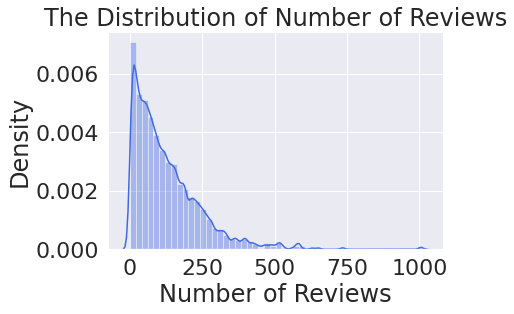

In [265]:
sns.set(font_scale = 2)
plt.figure()
sns.distplot(dfmergeClean['number_of_reviews'],axlabel = 'Number of Reviews',hist=True,kde=True,color='royalblue')
plt.title("The Distribution of Number of Reviews")
plt.show()

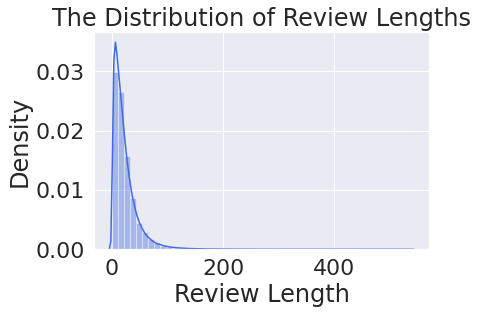

In [264]:
sns.set(font_scale = 2)
plt.figure()
sns.distplot(dfmergeClean['review_len'],axlabel = 'Review Length',hist=True,kde=True,color='royalblue')
plt.title("The Distribution of Review Lengths")
plt.show()

## Topic Modeling and Latent Dirichlet Allocation (LDA)

Topic modeling is a type of statistical modeling for discovering the abstract “topics” that occur in a collection of documents. Latent Dirichlet Allocation (LDA) is an example of topic model and is used to classify text in a document to a particular topic. It builds a topic per document model and words per topic model, modeled as Dirichlet distributions. Reference: https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24.

The reason why we employ this NLP method is that it has good performance for modeling the topics and could help pave the basis for sentiment analysis later. Also, as we do not have training sets with tag labels, this model would be more proper than deep learning models such as LSTM which requires training set tags.

In [73]:
# we would remove the reviews with fewer than 10 tokens
dfLDA = dfmergeClean[dfmergeClean['review_len'] >= 10]

In [74]:
dic= corpora.Dictionary(dfLDA['dataCleaned'])
# We would filter out words that show in < 15 reviews, or display > 75% of the reviews as they would not be helpful
dic.filter_extremes(no_below = 15, no_above = .75)
textsLDA = dfLDA['dataCleaned']
corpus = [dic.doc2bow(text) for text in textsLDA] 

In [75]:
#We would then train the LDA model
ldaAir = gensim.models.ldamodel.LdaModel(corpus = corpus, id2word = dic, num_topics = 9, passes = 20)

In [76]:
# print topic and words contributing to each topic
topics = ldaAir.print_topics(num_words = 10)
for topic in topics:  
    print(topic)

(0, '0.050*"great" + 0.042*"restaurant" + 0.033*"close" + 0.030*"location" + 0.026*"subway" + 0.025*"place" + 0.022*"walking" + 0.019*"distance" + 0.019*"apartment" + 0.018*"store"')
(1, '0.035*"parking" + 0.022*"place" + 0.020*"night" + 0.019*"street" + 0.019*"city" + 0.015*"day" + 0.013*"get" + 0.012*"nyc" + 0.012*"find" + 0.011*"spot"')
(2, '0.058*"walk" + 0.045*"10" + 0.042*"subway" + 0.033*"train" + 0.030*"station" + 0.029*"minutes" + 0.028*"manhattan" + 0.027*"away" + 0.025*"close" + 0.024*"square"')
(3, '0.066*"great" + 0.064*"stay" + 0.051*"place" + 0.040*"clean" + 0.034*"would" + 0.033*"location" + 0.032*"recommend" + 0.030*"host" + 0.026*"definitely" + 0.017*"super"')
(4, '0.040*"stay" + 0.034*"home" + 0.031*"airbnb" + 0.028*"place" + 0.023*"make" + 0.021*"host" + 0.021*"like" + 0.017*"amaze" + 0.017*"best" + 0.015*"feel"')
(5, '0.028*"room" + 0.013*"bed" + 0.013*"bathroom" + 0.012*"clean" + 0.011*"stay" + 0.010*"good" + 0.010*"nice" + 0.010*"place" + 0.009*"apartment" + 0.00

In [77]:
# save the LDA model so no need to train again
ldaAir.save('topicReview.model')

In [78]:
#Visualize the topics. It is better than word cloud since it is user interactive.
# load saved lda model and print topics
loading = LdaModel.load('topicReview.model')
# visualize the model and data
pyLDAvis.enable_notebook()
picLDAreview = pyLDAvis.gensim.prepare(ldaAir, corpus, dic)
picLDAreview

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.031947  0.167497       1        1  17.023918
5     -0.091243 -0.054932       2        1  16.492573
6     -0.008934  0.099335       3        1  13.767595
4     -0.196626  0.028347       4        1  11.448353
0      0.245937  0.070613       5        1  11.050395
7     -0.216443 -0.208274       6        1   9.308563
8     -0.005719  0.234946       7        1   8.122821
1     -0.020896 -0.160598       8        1   6.908685
2      0.325872 -0.176935       9        1   5.877097, topic_info=         Term           Freq          Total Category  logprob  loglift
12      great  388017.000000  388017.000000  Default  30.0000  30.0000
172        us  106776.000000  106776.000000  Default  29.0000  29.0000
232     check  110684.000000  110684.000000  Default  28.0000  28.0000
59       walk   80519.000000   80519.000000  Default  27.0000  27.0000
56     subway  105181.000000  105181.000000  Default  26.0000  26.0000
..        ...            ...            ...      ...      ...      ...
813     metro    7273.495558   15853.166386   Topic9  -4.9279   2.0550
243       get   12270.149920   97612.260597   Topic9  -4.4050   0.7603
81     locate    8366.576256   42956.245256   Topic9  -4.7879   1.1982
16   location    9251.353734  225536.799732   Topic9  -4.6874  -0.3596
45       good    8135.694990  125767.427178   Topic9  -4.8159   0.0959

[634 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
277       9  0.999977       10
2756      8  0.999549       11
344       9  0.999925       15
1005      9  0.999836       20
101       8  0.999670       24
...     ...       ...      ...
39        3  0.999973     york
1480      3  0.999480   yorker
2426      3  0.998953  yorkers
1320      8  0.999527    young
366       1  0.998551      zen

[1186 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 6, 7, 5, 1, 8, 9, 2, 3])

From the dashboard, we can see that the most important factors that affect evaluations are feelings of the apartment, room conditions, 
as well as traffic covenience.

In [79]:
# save pyldavis results
pyLDAvis.save_html(picLDAreview,'visReview.html')

## Sentiment Analysis

In [80]:
sentimentReview = SentimentIntensityAnalyzer()
# calculate and get polarity scores for each line of review into a dictionary
polarity_scores = [sentimentReview.polarity_scores(review) for review in dfmergeClean['comments']]

In [81]:
dfmergeCleanSen = dfmergeClean.copy()
dfmergeCleanSen['compound'] = [score['compound'] for score in polarity_scores]#overall sentiment
dfmergeCleanSen['negativity'] = [score['neg'] for score in polarity_scores]
dfmergeCleanSen['neutrality'] = [score['neu'] for score in polarity_scores]
dfmergeCleanSen['positivity'] = [score['pos'] for score in polarity_scores]

In [82]:
#dfmergeCleanSen.to_csv('reviewSentiment1.csv', index = False)

# Image Analysis: K-Means Clustering and OpenCV, Detecting the Color Tone of the Pictures

This section would analyze the pictures posted by the hosts for the Airbnb houses. Our main goal in this section is to detect the overall color tone of the picture, as our hypothesis is that the color tone would affect the buyers' willingness to rent. In other words, we suppose warm and cool colors would have different impacts on consumers' feelings, so their desire to rent would diversify by this variable.

The reason we employ K-Means is that a picture can be complicated. Using K-Means can help us reduce the dimensions of the pictures. After getting the clustered pictures, it would be much easier for us to deal with them and get the main color tone. OpenCV is a great and mature module that can help us detect the main color accurately. It is widely used in academic research and commercial world.

## Load Datasets, Define Useful Functions

In [83]:
from __future__ import print_function
import binascii
import struct
from PIL import Image
import numpy as np
import scipy
import scipy.misc
import scipy.cluster

import cv2, numpy as np
from sklearn.cluster import KMeans
import urllib.request
import requests 

In [84]:
#function for getting main color
def get_dominant_color(pil_img):
    img = pil_img.copy()
    img.convert("RGB")
    img.resize((1, 1), resample=0)
    dominant_color = img.getpixel((0, 0))
    return dominant_color

def visualize_colors(cluster, centroids):
    # Get the number of different clusters, create histogram, and normalize
    labels = np.arange(0, len(np.unique(cluster.labels_)) + 1)
    (hist, _) = np.histogram(cluster.labels_, bins = labels)
    hist = hist.astype("float")
    hist /= hist.sum()

    # Create frequency rect and iterate through each cluster's color and percentage
    rect = np.zeros((50, 300, 3), dtype=np.uint8)
    colors = sorted([(percent, color) for (percent, color) in zip(hist, centroids)])
    start = 0
    for (percent, color) in colors:
        print(color, "{:0.2f}%".format(percent * 100))
        end = start + (percent * 300)
        cv2.rectangle(rect, (int(start), 0), (int(end), 50), \
                      color.astype("uint8").tolist(), -1)
        start = end
    return rect

## Apply K-Means Clustering to the Pictures and then Break the Integrated Colors to three Layers: R, G, B

In [85]:
NUM_CLUSTERS = 5
badlistid = []
Rlist = []
Glist = []
Blist = []

In [87]:
df = listings.copy()

In [ ]:
#Due to disk storage constraint, we could not use all the pics, but only the first 9608 ones. However, since this is also a large volume, we suppose it should 
#be enough for us to draw conclusions.

In [ ]:
for i in range(0,9609):
    response = requests.get(df['picture_url'][i])
    if response.status_code != 200: #check if there is an error
        badlistid.append(df['id'][i])
        continue
    urllib.request.urlretrieve(df['picture_url'][i],"pics/images{}.jpg".format(i))
    img = Image.open("pics/images{}.jpg".format(i))
    im = img.resize((200, 200),Image.ANTIALIAS) 
    ar = np.asarray(im)
    shape = ar.shape
    ar = ar.reshape(scipy.product(shape[:2]), shape[2]).astype(float)

    codes, dist = scipy.cluster.vq.kmeans(ar, NUM_CLUSTERS)

    vecs, dist = scipy.cluster.vq.vq(ar, codes)         # assign codes
    counts, bins = scipy.histogram(vecs, len(codes))    # count occurrences

    index_max = scipy.argmax(counts)                    # find most frequent
    print(i)
    peak = codes[index_max]
    Rlist.append(peak[0])
    Glist.append(peak[1])
    Blist.append(peak[2])

In [ ]:
#merge R,G,B into the dataframe
mediationDicR = {'R':Rlist}
mediationdfR = pd.DataFrame(mediationDicR)
mediationDicG = {'G':Glist}
mediationdfG = pd.DataFrame(mediationDicG)
mediationDicB = {'B':Blist}
mediationdfB = pd.DataFrame(mediationDicB)
# get the subdataframe that does not contain missing pics and deleted profiles 
dfsub=df[0:9609]
dfsub1 = dfsub[~dfsub.id.isin(badlistid)]
dfsub2 = dfsub1.reset_index()
del dfsub2['index']
dfmergeR = pd.concat([dfsub2,mediationdfR],axis=1)
dfmergeG = pd.concat([dfmergeR,mediationdfG],axis=1)
dfmergeB = pd.concat([dfmergeG,mediationdfB],axis=1)
#define warm tone. If R is larger than B, then it is warm color. Otherwise cool.
dfmergeB['warm']=0
dfmergeB.loc[dfmergeB.R>dfmergeB.B,'warm']=1
dfmergeB['warm'].describe()


In [ ]:
#save it into a csv file. Since I have run the code before using my previous script, I did not run it again as it is very time-consuming.
#dfmerge1 = pd.read_csv('dfmerge.csv',encoding = "ISO-8859-1")

In [91]:
#load the files
dfNew = pd.read_csv('dfmergeB.csv',encoding = "ISO-8859-1")
dfNew.head()

,id,listing_url,date,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,...,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,R,G,B,warm
0,2595,https://www.airbnb.com/rooms/2595,2021/9/2,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,https://a0.muscache.com/pictures/f0813a11-40b2...,2845,https://www.airbnb.com/users/show/2845,Jennifer,...,f,3,3,0,0,0.33,145.469269,118.032120,94.797308,1
1,3831,https://www.airbnb.com/rooms/3831,2021/9/2,"Whole flr w/private bdrm, bath & kitchen(pls r...","Enjoy 500 s.f. top floor in 1899 brownstone, w...",Just the right mix of urban center and local n...,https://a0.muscache.com/pictures/e49999c2-9fd5...,4869,https://www.airbnb.com/users/show/4869,LisaRoxanne,...,f,1,1,0,0,5.03,41.886548,43.327513,42.936160,0
2,5121,https://www.airbnb.com/rooms/5121,2021/9/2,BlissArtsSpace!,<b>The space</b><br />HELLO EVERYONE AND THANK...,NaN,https://a0.muscache.com/pictures/2090980c-b68e...,7356,https://www.airbnb.com/users/show/7356,Garon,...,f,1,0,1,0,0.54,149.949516,125.157799,45.749798,1
3,5136,https://www.airbnb.com/rooms/5136,2021/9/2,"Spacious Brooklyn Duplex, Patio + Garden",We welcome you to stay in our lovely 2 br dupl...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,7378,https://www.airbnb.com/users/show/7378,Rebecca,...,f,1,1,0,0,0.02,214.687595,195.996314,179.204118,1
4,5178,https://www.airbnb.com/rooms/5178,2021/9/2,Large Furnished Room Near B'way,Please don't expect the luxury here just a bas...,"Theater district, many restaurants around here.",https://a0.muscache.com/pictures/12065/f070997...,8967,https://www.airbnb.com/users/show/8967,Shunichi,...,f,1,0,1,0,3.64,178.576734,138.710742,101.362392,1


In [283]:
#To try different feature representations, we also define another way of warm and cool.
dfNew['tone']=0
dfNew.loc[(dfNew.R>=dfNew.B) & (dfNew.R>=128),'tone']=1
dfNew.loc[(dfNew.B>dfNew.R) & (dfNew.B>=128),'tone']=2
dfNew['warmtone']=0
dfNew.loc[dfNew.tone==1,'warmtone']=1
dfNew['cooltone']=0
dfNew.loc[dfNew.tone==2,'cooltone']=1
#We made one hot encoders for warm tone and cool tone. It warmtone == 1, then it is warm color. It cooltone== 1, then it is cool color. 
#If both == 0, then it is  neutral.

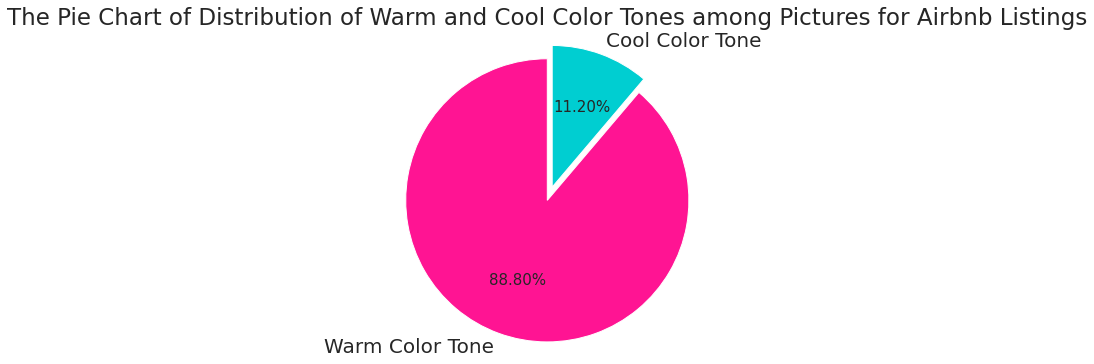

In [269]:
plt.figure(figsize=(6,6))
labels = [u'Warm Color Tone',u'Cool Color Tone']
sizes = [8530,1076] 
colors = ['#FF1493','#00CED1']
explode = (0.1,0) 
patches,text1,text2 = plt.pie(sizes,
                      explode=explode,
                      labels=labels,
                      colors=colors,
                      autopct = '%3.2f%%', 
                      shadow = False, 
                      startangle =90, 
                      pctdistance = 0.6)

for t in text1:
    t.set_size(20)
for t in text2:
    t.set_size(15)
plt.axis('equal')
#plt.legend()
plt.title("The Pie Chart of Distribution of Warm and Cool Color Tones among Pictures for Airbnb Listings", fontsize=23)
plt.show()

# Regression Analysis, Cross Validation, Alternative Measurement for Robustness Check, and Discussion

In this section, we would do regression analysis for the data, to predict the price the Airbnb houses. We employ various regression models for comparison, and use cross validation and validation sets in neural network to select the optimal parameters.

## Data Preparation

In [94]:
dfreview = pd.read_csv('reviewSentiment1.csv',encoding = "ISO-8859-1",lineterminator='\n')

In [95]:
dfreview.head()

,id,comments,host_is_superhost,price,number_of_reviews,review_scores_rating,autoreview,isen,dataCleaned,review_len,compound,negativity,neutrality,positivity
0,2595,Great experience.,f,$150.00,48.0,4.7,0,1,"['great', 'experience']",2,0.6249,0.000,0.196,0.804
1,2595,I've stayed with my friend at the Midtown Cast...,f,$150.00,48.0,4.7,0,1,"['stay', 'friend', 'midtown', 'castle', 'six',...",45,0.9248,0.016,0.793,0.192
2,2595,"We've been staying here for about 9 nights, en...",f,$150.00,48.0,4.7,0,1,"['stay', 'night', 'enjoy', 'center', 'city', '...",30,0.9229,0.000,0.808,0.192
3,2595,We had a wonderful stay at Jennifer's charming...,f,$150.00,48.0,4.7,0,1,"['wonderful', 'stay', 'charm', 'apartment', 'o...",12,0.9464,0.000,0.510,0.490
4,2595,Hi to everyone!\rWould say our greatest compli...,f,$150.00,48.0,4.7,0,1,"['hi', 'everyone', 'would', 'say', 'greatest',...",50,0.9869,0.000,0.729,0.271


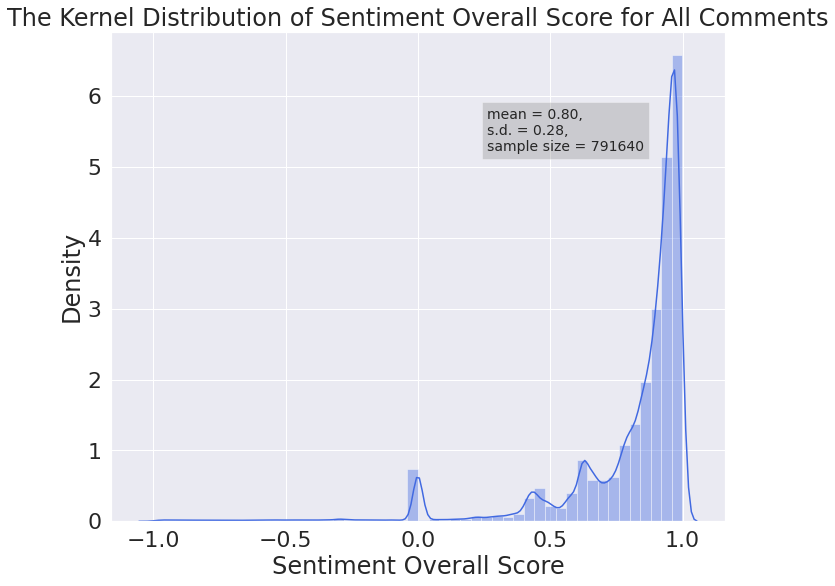

In [298]:
sns.set(font_scale = 2)
plt.figure()
sns.distplot(dfreview['compound'],axlabel = 'Sentiment Overall Score',hist=True,kde=True,color='royalblue')
t = ('mean = 0.80,\n'
     's.d. = 0.28,\n'
     'sample size = 791640')
plt.figtext(0.6, 0.7, t, fontsize=14, wrap=True,bbox ={'facecolor':'grey',  
                   'alpha':0.3, 'pad':5})
plt.title("The Kernel Distribution of Sentiment Overall Score for All Comments")
plt.show()

In [96]:
#remove wrong lines whose ids are not digits
dfreview1 = dfreview[dfreview['id'].apply(lambda x: str(x).isdigit())]
#summarize all the reviews for each listing
dfreviewOverall = dfreview1.groupby(['id'])['compound'].mean().reset_index()
dfreviewP = dfreview1.groupby(['id'])['positivity'].mean().reset_index()
dfreviewN = dfreview1.groupby(['id'])['negativity'].mean().reset_index()
#make the id numeric
dfreviewOverall["id"] = pd.to_numeric(dfreviewOverall["id"])
dfreviewP["id"] = pd.to_numeric(dfreviewP["id"])
dfreviewN["id"] = pd.to_numeric(dfreviewN["id"])
#merge all of these summary dfs
dfmergeReview = pd.merge(dfNew,dfreviewOverall,on=['id'],how='left')
dfmergeReview = pd.merge(dfmergeReview,dfreviewP,on=['id'],how='left')
dfmergeReview = pd.merge(dfmergeReview,dfreviewN,on=['id'],how='left')

dfmergeReview.head()

,id,listing_url,date,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,...,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,R,G,B,warm,compound,positivity,negativity
0,2595,https://www.airbnb.com/rooms/2595,2021/9/2,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,https://a0.muscache.com/pictures/f0813a11-40b2...,2845,https://www.airbnb.com/users/show/2845,Jennifer,...,0,0,0.33,145.469269,118.032120,94.797308,1,0.784377,0.321614,0.018432
1,3831,https://www.airbnb.com/rooms/3831,2021/9/2,"Whole flr w/private bdrm, bath & kitchen(pls r...","Enjoy 500 s.f. top floor in 1899 brownstone, w...",Just the right mix of urban center and local n...,https://a0.muscache.com/pictures/e49999c2-9fd5...,4869,https://www.airbnb.com/users/show/4869,LisaRoxanne,...,0,0,5.03,41.886548,43.327513,42.936160,0,0.787390,0.322857,0.014694
2,5121,https://www.airbnb.com/rooms/5121,2021/9/2,BlissArtsSpace!,<b>The space</b><br />HELLO EVERYONE AND THANK...,NaN,https://a0.muscache.com/pictures/2090980c-b68e...,7356,https://www.airbnb.com/users/show/7356,Garon,...,1,0,0.54,149.949516,125.157799,45.749798,1,0.875212,0.360245,0.011327
3,5136,https://www.airbnb.com/rooms/5136,2021/9/2,"Spacious Brooklyn Duplex, Patio + Garden",We welcome you to stay in our lovely 2 br dupl...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,7378,https://www.airbnb.com/users/show/7378,Rebecca,...,0,0,0.02,214.687595,195.996314,179.204118,1,0.990100,0.266500,0.012500
4,5178,https://www.airbnb.com/rooms/5178,2021/9/2,Large Furnished Room Near B'way,Please don't expect the luxury here just a bas...,"Theater district, many restaurants around here.",https://a0.muscache.com/pictures/12065/f070997...,8967,https://www.airbnb.com/users/show/8967,Shunichi,...,1,0,3.64,178.576734,138.710742,101.362392,1,0.728178,0.263077,0.024644


In [100]:
# Remove the rows where the houses do not have a single reivew and rating
dfNew3 = dfmergeReview[dfmergeReview.compound.notna()]
dfNew3 = dfNew3[dfNew3['review_scores_rating'].notna()]

In [113]:
#remove '$'
dfNew3['price1'] = dfNew3['price'].str.extract('(\d+)', expand=False)
dfNew3['price1'] = dfNew3['price1'].astype(float)

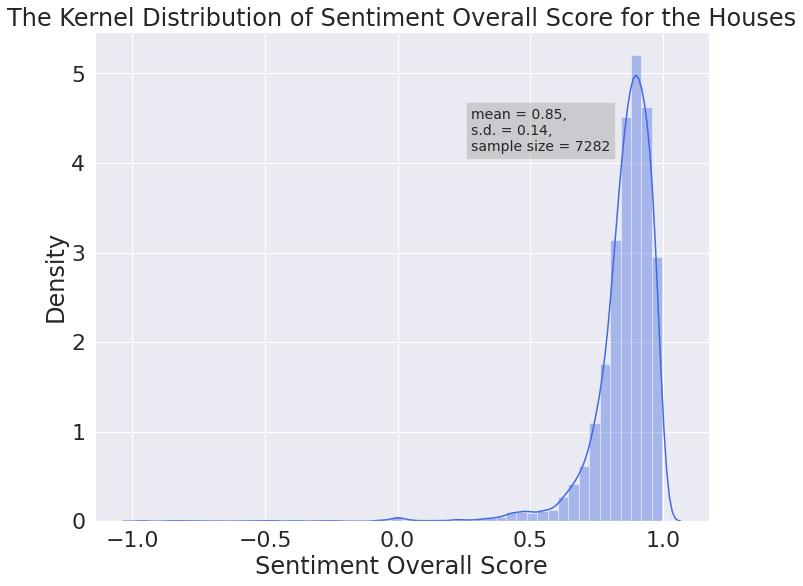

In [302]:
sns.set(font_scale = 2)
plt.figure()
sns.distplot(dfNew3['compound'],axlabel = 'Sentiment Overall Score',hist=True,kde=True,color='royalblue')
t = ('mean = 0.85,\n'
     's.d. = 0.14,\n'
     'sample size = 7282')
plt.figtext(0.6, 0.7, t, fontsize=14, wrap=True,bbox ={'facecolor':'grey',  
                   'alpha':0.3, 'pad':5})
plt.title("The Kernel Distribution of Sentiment Overall Score for the Houses")
plt.show()

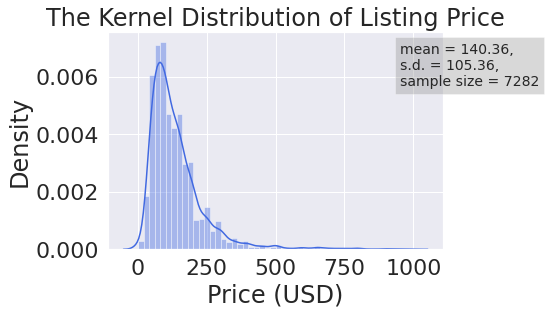

In [273]:
#See the Kernel Distribution of Listing Price
sns.set(font_scale = 2)
plt.figure()
sns.distplot(dfNew3['price1'],axlabel = 'Price (USD)',hist=True,kde=True,color='royalblue')
t = ('mean = 140.36,\n'
     's.d. = 105.36,\n'
     'sample size = 7282')
plt.figtext(0.8, 0.7, t, fontsize=14, wrap=True,bbox ={'facecolor':'grey',  
                   'alpha':0.3, 'pad':5})
plt.title("The Kernel Distribution of Listing Price")
plt.show()

## Linear Regression

In this and subsequent subsections, we would run regression analysis using marketing domain knowledge. We would firstly select important features, and then employ them for our regression analysis. Essentials that we select out include picture warm color tone (1 or 0), the overall review sentiment, number of reviews indicating past number of evaluations, star rating, minimum nights to stay for a booking, the number of capacity for accomodates, locations.

In [136]:
dfML = dfNew3[['price1','warm','compound','number_of_reviews','review_scores_rating','minimum_nights','accommodates','latitude','longitude']]
dfML

,price1,warm,compound,number_of_reviews,review_scores_rating,minimum_nights,accommodates,latitude,longitude
0,150.0,1,0.784377,48,4.70,30,1,40.75356,-73.98559
1,76.0,0,0.787390,408,4.46,1,3,40.68494,-73.95765
2,60.0,1,0.875212,50,4.52,30,2,40.68535,-73.95512
3,275.0,1,0.990100,2,5.00,5,4,40.66265,-73.99454
4,68.0,1,0.728178,490,4.21,2,2,40.76457,-73.98317
...,...,...,...,...,...,...,...,...,...
9598,105.0,1,0.799383,6,4.00,30,2,40.74697,-74.00327
9599,50.0,1,0.634957,8,4.00,30,2,40.72658,-73.97770
9600,160.0,1,0.862412,84,4.89,7,3,40.79614,-73.94867
9601,60.0,1,0.931175,4,5.00,1,3,40.72564,-73.94950


Text(0.5, 1.0, 'Correlation between Price and features')

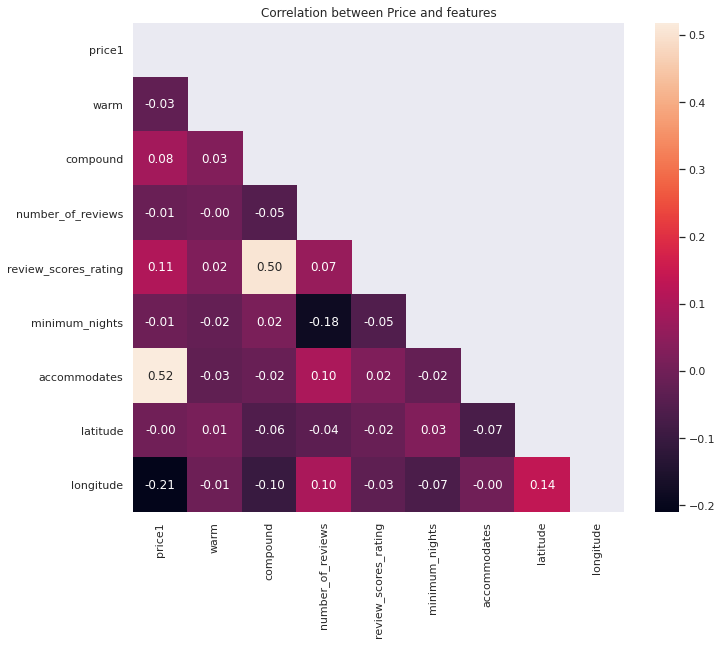

In [276]:
#See the Correlation between Price and features
corr = dfML.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
plt.rcParams['figure.figsize'] = [11, 9]
sns.set(font_scale = 1)
sns.heatmap(corr, mask=mask, annot = True, fmt='.2f')
plt.title(label= "Correlation between Price and features", fontdict=None, loc='center', pad=None)

Text(0.5, 1.1, 'Relationship with Accommodates & Price')

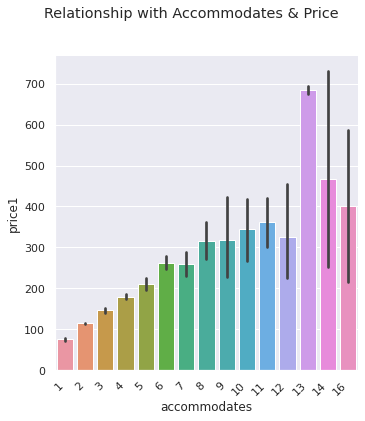

In [282]:
relapic =sns.catplot (x='accommodates', y='price1',  kind ='bar', data= dfML)

relapic.set_xticklabels(rotation =45, horizontalalignment='right')

relapic.fig.suptitle("\n".join(["Relationship with Accommodates & Price"]), y=1.1)

In [137]:
dfMLvalue = dfML.values
X = dfMLvalue[:,(1,2,3,4,5,6,7,8)]
Y = dfMLvalue[:,0] 
Y = Y.astype('int')

In [126]:
trainX, testX, trainY, testY = \
    model_selection.train_test_split(X, Y,
    train_size=0.7, test_size=0.3, random_state=4487)
print(trainX.shape)
print(testX.shape)

(5097, 8)
(2185, 8)


In [140]:
print(trainY.shape)
print(testY.shape)

(5097,)
(2185,)


In [127]:
from sklearn import *
ols = linear_model.LinearRegression()
ols.fit(trainX,trainY)

LinearRegression()

In [128]:
ols.score(trainX,trainY)

0.3164353768209377

In [129]:
ols.predict(testX)

array([ 94.91705275,  88.54707943, 117.57577703, ..., 229.41623719,
        76.6384306 , 281.23694499])

In [307]:
print(ols.coef_)

[-6.26872464e+00  2.92730525e+01 -7.75581438e-02  1.90493988e+01
 -2.23836556e-02  3.20466229e+01  1.39959703e+02 -5.78008277e+02]


Most of the cofficients are within our expectations. A higher review sentiment score leads to a higher price, and the same goes for rating, accomodation capacity. However, to our surprise, cool-color-toned houses have better price. We suppose it can be attribtued to the fact that they are perceived as more comfortable, rare, and elegant.

In [125]:
def eval_predict(trueY, predY):
    MAE = metrics.mean_absolute_error(trueY, predY)
    RMSE = sqrt(metrics.mean_squared_error(trueY, predY))
    return RMSE, MAE

# function to make a scatter plot
def plot_scatter(testY, predY, titlestr):
    plt.scatter(testY, predY, s=1)
    plt.plot([min(testY),max(testY)], [min(testY),max(testY)], 'r-')
    plt.xlabel('true')
    plt.ylabel('prediction')
    r1,r2 = eval_predict(testY, predY)
    plt.title(titlestr + "\n(RMSE={:.3f}; MAE={:.3f})".format(r1,r2))
    plt.grid(True)

In [134]:
from numpy import *
trainerr={}; testerr={}

trainerr['err'] = eval_predict(trainY, ols.predict(trainX))
testerr['err']  = eval_predict(testY, ols.predict(testX))

print("train error: (RMSE,MAE)=", trainerr['err'] )
print("test error: (RMSE,MAE)=", testerr['err'] )

train error: (RMSE,MAE)= (87.73313282484548, 54.95473903630159)
test error: (RMSE,MAE)= (83.11870479116455, 52.90153210330531)


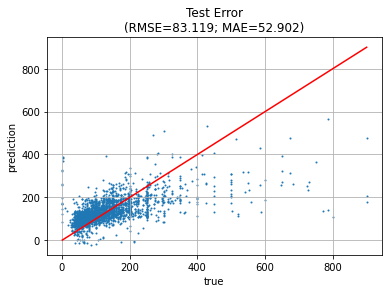

In [135]:
# The test error
plot_scatter(testY, ols.predict(testX), 'Test Error')

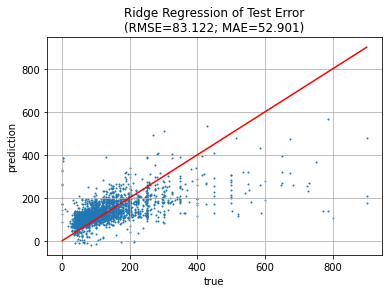

In [147]:
# Ridge Regresssion
alphas = logspace(-3,6,50)
rr = linear_model.RidgeCV(alphas=alphas, cv=5)
rr.fit(trainX, trainY)
plot_scatter(testY, rr.predict(testX), 'Ridge Regression of Test Error')

In [148]:
# Lasso 
alphas = logspace(-3,6,50)
las = linear_model.LassoCV(alphas=alphas, cv=5)
las.fit(trainX, trainY)

LassoCV(alphas=array([1.00000000e-03, 1.52641797e-03, 2.32995181e-03, 3.55648031e-03,
       5.42867544e-03, 8.28642773e-03, 1.26485522e-02, 1.93069773e-02,
       2.94705170e-02, 4.49843267e-02, 6.86648845e-02, 1.04811313e-01,
       1.59985872e-01, 2.44205309e-01, 3.72759372e-01, 5.68986603e-01,
       8.68511374e-01, 1.32571137e+00, 2.02358965e+00, 3.08884360e+00,
       4.71486636e+00, 7.19685673e+0...
       2.55954792e+01, 3.90693994e+01, 5.96362332e+01, 9.10298178e+01,
       1.38949549e+02, 2.12095089e+02, 3.23745754e+02, 4.94171336e+02,
       7.54312006e+02, 1.15139540e+03, 1.75751062e+03, 2.68269580e+03,
       4.09491506e+03, 6.25055193e+03, 9.54095476e+03, 1.45634848e+04,
       2.22299648e+04, 3.39322177e+04, 5.17947468e+04, 7.90604321e+04,
       1.20679264e+05, 1.84206997e+05, 2.81176870e+05, 4.29193426e+05,
       6.55128557e+05, 1.00000000e+06]),
        cv=5)

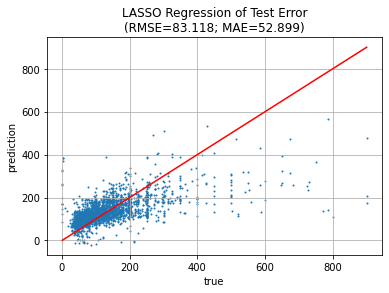

In [149]:
plot_scatter(testY, las.predict(testX), 'LASSO Regression of Test Error')

## Random Forest

In [138]:
### Simple RF
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=5, random_state=0)
regr.fit(trainX, trainY)

RandomForestRegressor(max_depth=5, random_state=0)

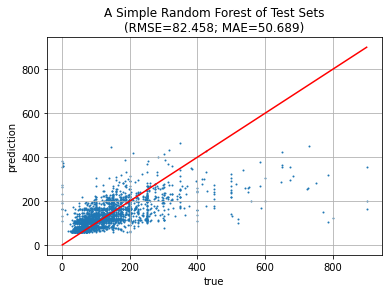

In [139]:
plot_scatter(testY, regr.predict(testX), 'A Simple Random Forest of Test Sets')

In [141]:
### RF with CV
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [20, 30, 40, 50],
    'max_features': [2, 3,4],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 500,1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
rf_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

rf_search.fit(trainX, trainY)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 553 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 918 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done 1363 tasks      | elapsed: 26.9min
[Parallel(n_jobs=-1)]: Done 1890 tasks      | elapsed: 36.0min
[Parallel(n_jobs=-1)]: Done 2497 tasks      | elapsed: 46.6min
[Parallel(n_jobs=-1)]: Done 2700 out of 2700 | elapsed: 50.6min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [20, 30, 40, 50],
                         'max_features': [2, 3, 4],
                         'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300, 500, 1000]},
             verbose=2)

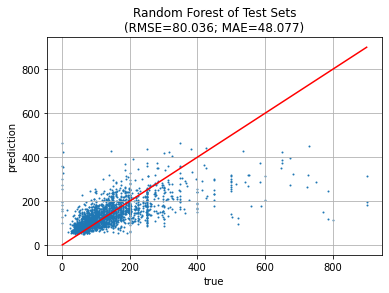

In [142]:
plot_scatter(testY, rf_search.predict(testX), 'Random Forest of Test Sets')

## Nonlinear Regression

In [143]:
polylin = pipeline.Pipeline([
        ('polyfeats', preprocessing.PolynomialFeatures(degree=1)), 
        ('linreg',    linear_model.LinearRegression())
    ])


paramgrid = {
    "polyfeats__degree": array([1, 2, 3, 4, 5]),
}

# do the cross-validdation search - use -MSE as the score for maximizing
bestploy = model_selection.GridSearchCV(polylin, paramgrid, cv=5, n_jobs=-1,
                                      scoring='neg_mean_squared_error')
bestploy.fit(trainX,trainY)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('polyfeats',
                                        PolynomialFeatures(degree=1)),
                                       ('linreg', LinearRegression())]),
             n_jobs=-1,
             param_grid={'polyfeats__degree': array([1, 2, 3, 4, 5])},
             scoring='neg_mean_squared_error')

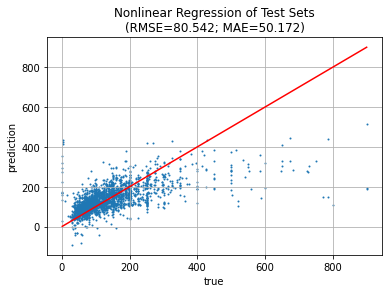

In [144]:
plot_scatter(testY, bestploy.predict(testX), 'Nonlinear Regression of Test Sets')

## Support Vector Machine

In [145]:
#RBF Kernel
paramgrid = {'C': logspace(-2,3,40),
'gamma': logspace(-4,3,40) }
#print(paramgrid)
# setup the cross-validation object
# pass the SVM object w/ rbf kernel, parameter grid, and number of CV folds
svmcv = model_selection.GridSearchCV(svm.SVR(kernel='rbf'), paramgrid, cv=5,
n_jobs=-1, verbose=True)
# run cross-validation (train for each split)
svmcv.fit(trainX,trainY);

Fitting 5 folds for each of 1600 candidates, totalling 8000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 354 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1154 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 1704 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 2354 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done 3104 tasks      | elapsed: 25.7min
[Parallel(n_jobs=-1)]: Done 3954 tasks      | elapsed: 32.7min
[Parallel(n_jobs=-1)]: Done 4904 tasks      | elapsed: 41.7min
[Parallel(n_jobs=-1)]: Done 5954 tasks      | elapsed: 52.9min
[Parallel(n_jobs=-1)]: Done 7104 tasks      | elapsed: 70.6min
[Parallel(n_jobs=-1)]: Done 8000 out of 8000 | elapsed: 91.8min finished


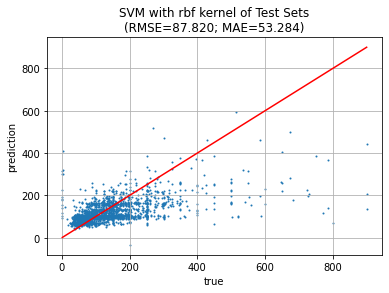

In [146]:
plot_scatter(testY, svmcv.predict(testX), 'SVM with rbf kernel of Test Sets')

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 79.1min finished


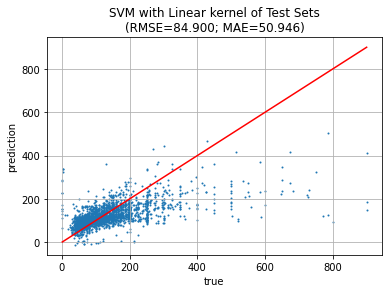

In [156]:
# Linear Kernrl
# kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}
paramgrid = {'C': logspace(-2,3,20) }

svmlin = model_selection.GridSearchCV(svm.SVR(kernel='linear'), paramgrid, cv=5,
n_jobs=-1, verbose=True)

svmlin.fit(trainX,trainY);
plot_scatter(testY, svmlin.predict(testX), 'SVM with Linear kernel of Test Sets')

Fitting 4 folds for each of 40 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  3.1min finished


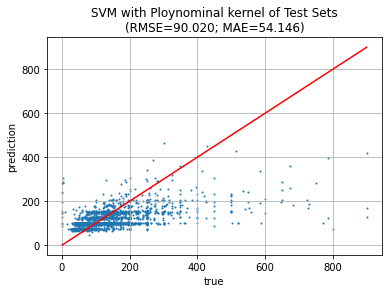

In [160]:
# Poly Kernel
paramgrid = {'C': logspace(-2,3,20),
'degree': [2,3] }


svmpoly = model_selection.GridSearchCV(svm.SVR(kernel='poly'), paramgrid, cv=4,
n_jobs=-1, verbose=True)

svmpoly.fit(trainX,trainY);
plot_scatter(testY, svmpoly.predict(testX), 'SVM with Ploynominal kernel of Test Sets')

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 354 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 1154 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 1704 tasks      | elapsed: 22.7min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed: 26.0min finished


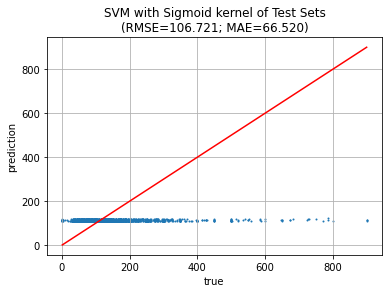

In [159]:
# Sigmoid Kernel

paramgrid = {'C': logspace(-2,3,20),
'gamma': logspace(-4,3,20) }


svmsig = model_selection.GridSearchCV(svm.SVR(kernel='sigmoid'), paramgrid, cv=5,
n_jobs=-1, verbose=True)

svmsig.fit(trainX,trainY);
plot_scatter(testY, svmsig.predict(testX), 'SVM with Sigmoid kernel of Test Sets')

## Neural Network

During training the Neural Network, we spilt 15% of the training data as the **validation set**. We monitor the performance of the model on the validation set. When the validation loss doesn't decrease under threshold after 5 epochs, the model will stop iterate and return the trained neural network. 


In [161]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend as K
import struct

In [226]:
def plot_history(history):    
    plt.plot(history.history['loss'], label="training loss ({:.6f})".format(history.history['loss'][-1]))
    plt.plot(history.history['val_loss'], label="validation loss ({:.6f})".format(history.history['val_loss'][-1]))
    plt.grid(True)
    plt.legend(loc="best", fontsize=9)
    plt.axis([0,len(history.history['loss']), min(history.history['val_loss']), max(history.history['loss'])])
    plt.xlabel('iteration')
    plt.ylabel('loss')

In [255]:
random.seed(4487)
nn = Sequential()

nn.add(Dense(20, kernel_initializer='normal',input_dim = trainX.shape[1], activation='relu'))

nn.add(Dense(40, kernel_initializer='normal',activation='relu'))

nn.add(Dense(80, kernel_initializer='normal',activation='relu'))
# The Output Layer :
nn.add(Dense(1,activation='linear'))



In [256]:
earlystop = keras.callbacks.EarlyStopping(
    monitor='val_loss',     # look at the validation loss
    min_delta=0.0001,       # threshold to consider as no change
    patience=5,             # stop if 5 epochs with no change
    verbose=1, mode='auto'
)
callbacks_list = [earlystop]

In [257]:
nn.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
# fit the network

history = nn.fit(trainX, trainY, # the input/output data
epochs=100, # number of iterations
batch_size=32, # batch size
validation_split=0.15, # ratio of data for validation
verbose=False,# set to True to see each iteration,
                 callbacks=callbacks_list
)

Epoch 00013: early stopping


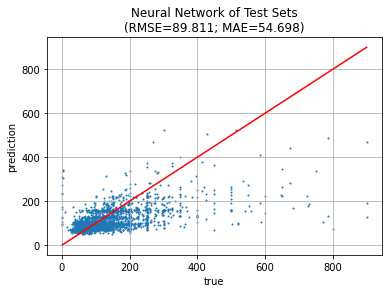

In [258]:
plot_scatter(testY, nn.predict(testX), 'Neural Network of Test Sets')

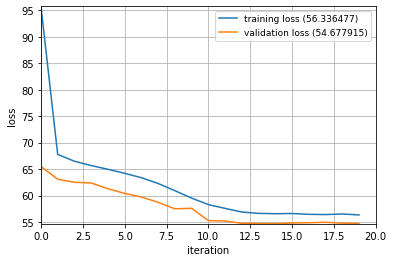

In [254]:
plot_history(history)

## Trying Different Feature Representations

In this subsection, we would try different feature representations, using a different measurement of color tone and review sentiment, and put them into the linear regression models. The results show that our model is robust.

In [285]:
dfmergeReviewAlt = pd.merge(dfNew,dfreviewOverall,on=['id'],how='left')
dfmergeReviewAlt = pd.merge(dfmergeReviewAlt,dfreviewP,on=['id'],how='left')
dfmergeReviewAlt = pd.merge(dfmergeReviewAlt,dfreviewN,on=['id'],how='left')
dfNew3Alt = dfmergeReviewAlt[dfmergeReviewAlt.compound.notna()]
dfNew3Alt = dfNew3Alt[dfNew3Alt['review_scores_rating'].notna()]
dfNew3Alt['price1'] = dfNew3Alt['price'].str.extract('(\d+)', expand=False)
dfNew3Alt['price1'] = dfNew3Alt['price1'].astype(float)
dfMLAlt = dfNew3Alt[['price1','warmtone','cooltone','positivity','negativity','number_of_reviews','review_scores_rating','minimum_nights','accommodates','latitude','longitude']]
dfMLAltvalue = dfMLAlt.values


In [286]:
dfMLAlt

,price1,warmtone,cooltone,positivity,negativity,number_of_reviews,review_scores_rating,minimum_nights,accommodates,latitude,longitude
0,150.0,1,0,0.321614,0.018432,48,4.70,30,1,40.75356,-73.98559
1,76.0,0,0,0.322857,0.014694,408,4.46,1,3,40.68494,-73.95765
2,60.0,1,0,0.360245,0.011327,50,4.52,30,2,40.68535,-73.95512
3,275.0,1,0,0.266500,0.012500,2,5.00,5,4,40.66265,-73.99454
4,68.0,1,0,0.263077,0.024644,490,4.21,2,2,40.76457,-73.98317
...,...,...,...,...,...,...,...,...,...,...,...
9598,105.0,0,0,0.345667,0.032500,6,4.00,30,2,40.74697,-74.00327
9599,50.0,0,0,0.375571,0.021429,8,4.00,30,2,40.72658,-73.97770
9600,160.0,1,0,0.312119,0.012403,84,4.89,7,3,40.79614,-73.94867
9601,60.0,0,0,0.413000,0.000000,4,5.00,1,3,40.72564,-73.94950


In [287]:
XAlt = dfMLAltvalue[:,(1,2,3,4,5,6,7,8,9,10)]
YAlt = dfMLAltvalue[:,0] 
YAlt = YAlt.astype('int')
trainXAlt, testXAlt, trainYAlt, testYAlt = \
    model_selection.train_test_split(XAlt, YAlt,
    train_size=0.7, test_size=0.3, random_state=4487)
olsAlt = linear_model.LinearRegression()
olsAlt.fit(trainXAlt,trainYAlt)
olsAlt.score(trainXAlt,trainYAlt)
olsAlt.predict(testXAlt)

array([ 87.50973418,  89.82772124, 137.37988723, ..., 228.19290444,
        82.49382725, 282.26867605])

In [291]:
from numpy import *
trainerr={}; testerr={}

trainerr['err'] = eval_predict(trainYAlt, olsAlt.predict(trainXAlt))
testerr['err']  = eval_predict(testYAlt, olsAlt.predict(testXAlt))

print("train error: (RMSE,MAE)=", trainerr['err'] )
print("test error: (RMSE,MAE)=", testerr['err'] )

train error: (RMSE,MAE)= (87.7188791913203, 55.03364593982764)
test error: (RMSE,MAE)= (83.17207509362645, 52.90876038326784)


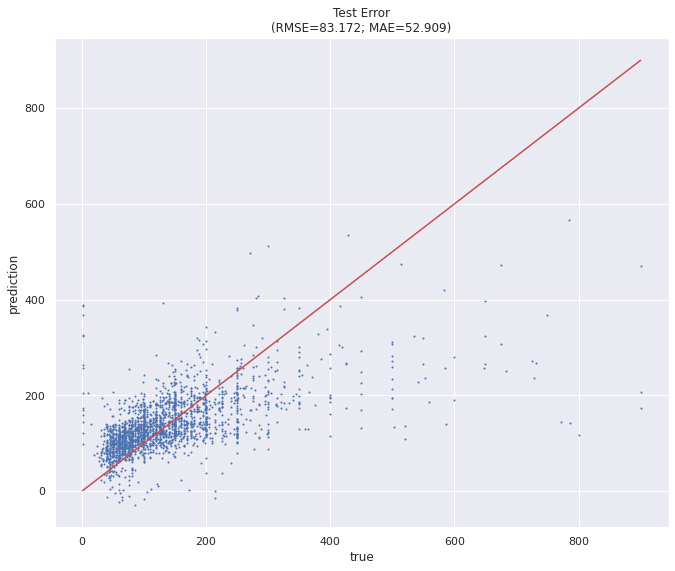

In [293]:
# The test error. The result is similar.
plot_scatter(testYAlt, olsAlt.predict(testXAlt), 'Test Error')

## Summary

| Model | RMSE | MAE |
|  :-  | --- | --- |
|Random Forest|80.036|48.077|
|Nonlinear Regression|80.542|50.172|
| OLS | 83.119 | 52.902 |
|Lasso|83.118|52.899|
|Ridge Regression|83.122|52.901|
|SVM (linear kernel)|84.900|50.946|
|SVM (rbf)|87.820|53.284|
|SVM (polynominal kernel)|90.020|54.146|
|SVM (sigmoid kernel)|106.721|66.520|

This table summarizes the mean squared error and mean absolute error of our models. We can find that the random forest has the best performance. 

Based on multiple decision trees, random forest merges them together to obtain more stable and accurate results. It introduces extra randomness. When training the model, the random forest can search automatically and sequentially for the best predictors among a random subset of features. Therefore, it has better generalizability and can provide a better prediction. Meanwhile, linear regression models impose more restrictive assumptions on the data. The underlying relationship between the characteristics of houses and their prices aren't linear, which leads to poor performance of the regression model.


# Conclusion and Discussion 

This project adopts machine learning algorithms to predict Airbnb house price based on features of houses, especially consumer reviews and color tone. 

Online reviews are an important factor influencing consumer decision-making. Consumers' first impression of a product is often impacted by online reviews. Our conclusions and analysis indicate that positive comments contribute to higher Airbnb house prices. Therefore, the owners of the house need to pay attention to the management of online word of mouth and their reputation. The color of the house also plays an essential role in determining the prices of Airbnb houses. Our results show that cool-toned houses tend to have higher prices, which is counterintutive. Our explanation is that on the one hand, when people see a room with cool colors, they often feel more comfortable. Therefore, it is likely that they are willing to pay a higher price for that cool-toned houses. On the other hand, warm-color houses are too common, while cool-color houses have a style of elegance, boosting its price.

The implementation of machine learning methods allows us to model the complex relationship between color tone as well as consumer reviews and Airbnb house prices. It not only helps us better understand consumer preferences, but also provides homeowners with some management insight.